In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from datetime import datetime

In [3]:
contacts = files.upload()
listings = files.upload()
users = files.upload()

Saving Contacts - Data.csv to Contacts - Data.csv


Saving Listings - Data.csv to Listings - Data.csv


Saving Users - Data.csv to Users - Data.csv


# Load dataset


In [ ]:
contact = pd.read_csv("Contacts - Data.csv")
listing = pd.read_csv("Listings - Data.csv")
user = pd.read_csv("Users - Data.csv")

In [5]:
#Dimensions of the dataset
print("contact = ",contact.shape,"\n listing = ",listing.shape,"\n user = ",user.shape)

contact =  (27887, 14) 
 listing =  (14614, 4) 
 user =  (36778, 3)


Preview of the datasets



In [ ]:
#contact.head(3)
#listing.head(3)
#user.head(3)

In [90]:
contact.info()
#listing.info()
#user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27887 entries, 0 to 27886
Data columns (total 14 columns):
id_guest_anon                           27887 non-null object
id_host_anon                            27887 non-null object
id_listing_anon                         27887 non-null object
ts_interaction_first                    27887 non-null object
ts_reply_at_first                       25855 non-null object
ts_accepted_at_first                    16415 non-null object
ts_booking_at                           11587 non-null object
ds_checkin_first                        27887 non-null object
ds_checkout_first                       27887 non-null object
m_guests                                27886 non-null float64
m_interactions                          27887 non-null int64
m_first_message_length_in_characters    27887 non-null float64
contact_channel_first                   27887 non-null object
guest_user_stage_first                  27887 non-null object
dtypes: float64(2), in

In [7]:
#contact.describe()
listing.describe()
#user.describe()

,total_reviews
count,14614.000000
mean,6.285548
std,16.203695
min,0.000000
25%,0.000000
50%,0.000000
75%,4.000000
max,269.000000


There are some listings with a negative "total_reviews". We will put those values to zero 

In [ ]:
listing[listing['total_reviews'] < 0] = 0
#listing.describe() #sanity check 

First takeaways:

> Contact:
On average the inquiries are for 3 guests, they exchange 9 messages and the first messages in 194 characters (phone text ~ 160 characters)


> Listing:
On average one listing has 7 reviews


In [95]:
#Check the null information 
contact.isnull().sum()
#listing.isnull().sum()
#user.isnull().sum()


id_user_anon             0
country                  1
words_in_user_profile    0
dtype: int64

# Data cleaning 

In [8]:
#Delete duplicates in user dataset 
user = user.drop_duplicates(["id_user_anon"])
user.shape

(31457, 3)

In [ ]:
#Merge inquiry + listing
sub = pd.merge(left = contact, right=listing, how='left', on='id_listing_anon')

In [10]:
#We want to make sure that users data refers to both the guest and the host
#We check if a(or b) is null or not
a = np.isin(user["id_user_anon"].unique() ,sub["id_host_anon"].unique()).sum()  
b = np.isin(user["id_user_anon"].unique() ,sub["id_guest_anon"].unique()).sum()
print(a,b)
#The user dataset contains id for both hosts and guests

8959 22566


In [11]:
 #Add the user(host/guest) data
data_with_host = pd.merge(left = sub, right = user, left_on="id_guest_anon", right_on="id_user_anon", how='left')
data_with_host.rename(columns= {"words_in_user_profile":"word_prof_guest", "country":"country_guest"}, inplace=True)
data = pd.merge(left = data_with_host, right = user, left_on="id_host_anon", right_on="id_user_anon", how='left')
data.rename(columns= {"words_in_user_profile":"word_prof_host", "country":"country_host"}, inplace=True)
data.drop(["id_user_anon_x","id_user_anon_y"], axis=1, inplace=True)
data.shape

(27887, 21)

# Feature engineering



*   Extract the month and year from the "ts_interaction_first" column and create the columns "month" and "year" that represent the date of the inquiry
*   Create the variable "booked" that represents whether the inquiry lead to a booking or not: it takes the values 1 (booked) or 0 (not booked)



In [ ]:
#Convert data to timestamp and creade features "month", "year"
data[["ts_interaction_first","ts_reply_at_first","ts_accepted_at_first","ts_booking_at","ds_checkin_first","ds_checkout_first"]] = data[["ts_interaction_first","ts_reply_at_first","ts_accepted_at_first","ts_booking_at","ds_checkin_first","ds_checkout_first"]].apply(pd.to_datetime) 
data['interaction_month'] = data['ts_interaction_first'].apply(lambda x: x.month)
data['interaction_year'] = data['ts_interaction_first'].apply(lambda x: x.year)

In [ ]:
#Create the feature "booked"
data["booked"] = data["ts_booking_at"].notnull().astype(int)

In [ ]:
#Check contact channel behavior 
# data[data.duplicated(["id_listing_anon"])].head(2)
# data[data["id_listing_anon"] == "4a41b40c-4c2f-410e-bd02-1cd60fabdd73" ].head(2)

In [32]:
data.head(3)

,id_guest_anon,id_host_anon,id_listing_anon,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests,m_interactions,m_first_message_length_in_characters,contact_channel_first,guest_user_stage_first,room_type,listing_neighborhood,total_reviews,country_guest,word_prof_guest,country_host,word_prof_host,interaction_month,interaction_year,booked
0,1630694d-6e19-463c-a5b9-bc5171322487,97fa1946-b2ac-41bd-854b-0039dc911495,e1f83a70-a590-4a2c-a138-6505f3e3de48,2016-01-17 13:33:32,2016-01-17 13:36:15,NaT,NaT,2016-02-06,2016-02-10,2.0,5,80.0,contact_me,new,Private room,Leme,130.0,BR,0,BR,68,1,2016,0
1,949d0029-4349-4611-9f78-a1990d48ff4a,7bb459cb-3b97-48e9-ba87-309e9dc809c7,b8ece1d0-ed4e-4def-a845-f3cb9f9c6d80,2016-03-15 01:00:48,2016-03-15 12:54:47,NaT,NaT,2016-03-18,2016-03-19,2.0,2,0.0,book_it,past_booker,Entire home/apt,-unknown-,0.0,BR,37,BR,10,3,2016,0
2,4d94ee7f-fd1e-4528-97ac-cf25335b15e5,b15572ec-7a34-4062-8d89-e2906b1a8a31,b4f23a9f-197b-4b3e-95fd-d5d759b11b0b,2016-04-16 22:16:19,2016-04-17 16:07:07,2016-04-17 19:40:47,NaT,2016-06-03,2016-06-05,2.0,5,44.0,contact_me,past_booker,Entire home/apt,-unknown-,0.0,BR,0,BR,0,4,2016,0


We can see that, depending on the circumstances a client can change the "channel"

# Analysis



> Metrics
- Number of bookings: The total number of booking for each listing
Computation: we sum the number of bookings for each listing via groupby
- Conversion rate: The ratio of the number of bookings over the number of inquiries made 









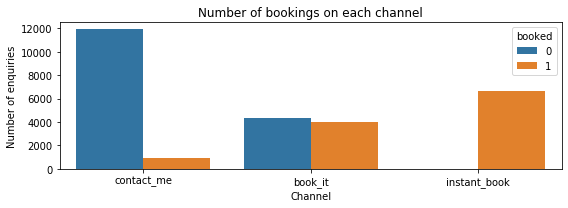

In [15]:
fig, ax = plt.subplots(figsize=(8,3))
sns.countplot(x='contact_channel_first',hue="booked", data=data, ax=ax)
ax.set_title('Number of bookings on each channel')
ax.set_ylabel("Number of enquiries")
ax.set_xlabel("Channel")

plt.tight_layout()



> Observations

> As we can see on the first graph "contact me" has the lowest conversion rate despite the fact that it represents almost half of the total number of inquiries

> As expected instant_book has 100% of conversion rate however there can be a room of improvement of the number of those types of inquiries which is only a quarter of all the inquiries

> We have a good yield on the book_it channel, we just have to increase the book_it offer.







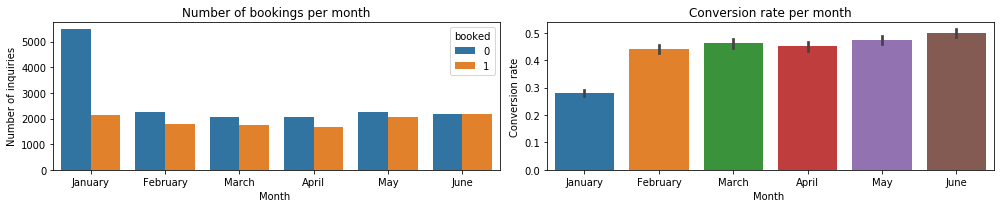

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,3))
sns.barplot(x='interaction_month', y='booked', data=data, ax=ax[1])
sns.countplot(x='interaction_month', hue='booked', data=data, ax=ax[0])
ax[0].set_title('Number of bookings per month')
ax[0].set_ylabel("Number of inquiries")
ax[0].set_xlabel("Month ")
ax[0].set(xticklabels=["January","February","March","April","May","June"])
ax[1].set_title('Conversion rate per month')
ax [1].set_ylabel("Conversion rate")
ax[1].set_xlabel("Month ")
ax[1].set(xticklabels=["January","February","March","April","May","June"])
plt.tight_layout()


> Observations:

January: It is the month with the most inquiries but with the lowest conversion rate (0.3). 

If we manage to increase the conversion rate in January we could double the number of bookings in that month. 
We will investigate what events may be causing this peak demand.


In [18]:
#Build a dataset with data of each listing 
grouped_list = data.groupby("id_listing_anon")[["ts_interaction_first","ts_booking_at"]].count().reset_index()
product = pd.merge(left=grouped_list, right=listing, on="id_listing_anon", how="left")
product.rename(columns={"id_listing_anon":"id_listing", "ts_interaction_first":"inquiries", "ts_booking_at":"bookings","listing_neighborhood":"neighborhood","total_reviews":"reviews"}, inplace=True)
product["conversion_rate"] = product["bookings"] / product["inquiries"]
product['conversion_rate'] = product['conversion_rate'].map(lambda n: '{:,.2%}'.format(n))
product.head(5)

,id_listing,inquiries,bookings,room_type,neighborhood,reviews,conversion_rate
0,0000527e-5d88-43e5-b40c-1931c9d12c38,1,0,Private room,Recreio dos Bandeirantes,0.0,0.00%
1,00030baf-b903-4d9a-9c33-ea4212cf48e1,1,1,Private room,-unknown-,0.0,100.00%
2,00046935-e2ae-4e0a-a549-30e975d40ddd,3,1,Entire home/apt,-unknown-,6.0,33.33%
3,00068b5f-4fb9-4b25-8814-830df5e68b23,1,0,Shared room,Copacabana,2.0,0.00%
4,000a1497-8e45-4abc-bafb-c99dd142b856,1,0,Entire home/apt,-unknown-,0.0,0.00%


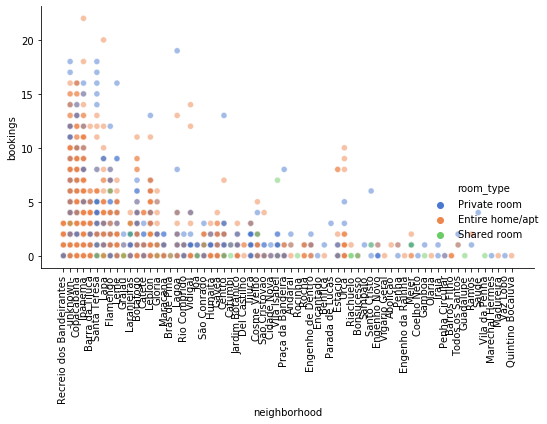

In [19]:
# fig, ax = plt.subplots(figsize=(10,6))
g = sns.relplot(x="neighborhood", y="bookings", hue="room_type", alpha=.5, palette="muted",height=6, data=product)
# g.set(ylim=(15, 35))
# g.set(xlim=(0,20))
g.set_titles("Inquiries/Bookings per listing")
g.set_xticklabels(rotation=90)
plt.tight_layout()

There is a good preference for Private room or Entire home/apt than a shared room

In [20]:
#Look for areas were to improve
neighborhood = product.groupby('neighborhood')[["inquiries","bookings"]].sum().reset_index()
neighborhood["conversion_rate"] = neighborhood["bookings"]/neighborhood["inquiries"]
neighborhood = neighborhood.sort_values(["inquiries","bookings"],ascending=[False, True])
neighborhood = neighborhood[neighborhood["neighborhood"] != "-unknown-"]
neighborhood.head(2)
#Here is a data set of each neighborhood

,neighborhood,inquiries,bookings,conversion_rate
14,Copacabana,6485,2853,0.439938
29,Ipanema,2991,1413,0.472417


> Neighborhood segmentation

We will segment neighborhood  given the number of inquiries and the number of bookings. 

high: The first segment will be areas with a good amount of inquiries and a good conversion rate 

medium: The silver segment will be those with the highest number of inquiries but the lowest number of bookings. These are areas were there is lot of unmet demand. We will need to find a way to make those listings more effecient in those areas

low: The third segment will be areas with a few inquiries where we need to grow the business.


In [21]:
#Neighborhood high
high = neighborhood[(neighborhood["bookings"] >= 20) & (neighborhood["conversion_rate"] > 0.6)]
high

,neighborhood,inquiries,bookings,conversion_rate
55,Santa Teresa,589,359,0.609508
62,Urca,78,48,0.615385
21,Estacio,33,21,0.636364


In [22]:
#Neighborhood silver
medium = neighborhood.copy()
medium.head(5)

,neighborhood,inquiries,bookings,conversion_rate
14,Copacabana,6485,2853,0.439938
29,Ipanema,2991,1413,0.472417
36,Leblon,1019,473,0.464181
3,Barra da Tijuca,997,364,0.365095
7,Botafogo,751,303,0.403462


In [23]:
#Neighborhood bronze
low = neighborhood[neighborhood["inquiries"] <10]
low.head(2)

,neighborhood,inquiries,bookings,conversion_rate
45,Penha Circular,8,0,0.00
18,Engenho Novo,8,2,0.25


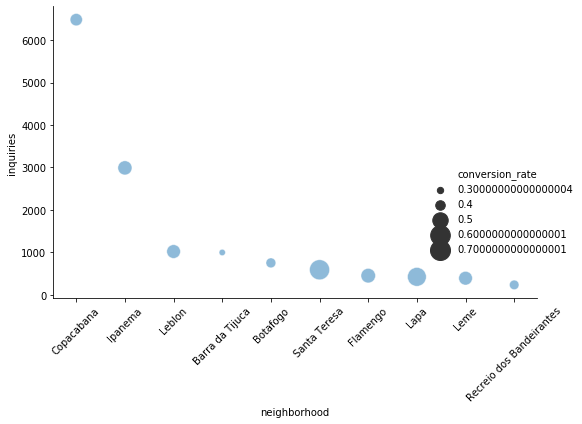

In [24]:
# fig, ax = plt.subplots(figsize=(10,6))
targeted_neighborhood = neighborhood.head(10).copy()
g = sns.relplot(x="neighborhood", y="inquiries", size="conversion_rate",sizes=(40, 400), alpha=.5, palette="muted",height=6, data=targeted_neighborhood)
# g.set(ylim=(15, 35))
g.set_titles("Inquiries/Bookings per listing")
g.set_xticklabels(rotation=45)
plt.tight_layout()

These 

## Classification

This is a binary classification. We intend to predict given the different features if the inquiry will lead to a booking or not. We will use here a Xgboost given the amount of data that we have. We will also pay attention to the required amount of computing power 

1.   Dependent variable: "booked"
2.   Independent variables: "other variables"


Faster training speed and higher efficiency.
Lower memory usage.
Better accuracy.
Support of parallel and GPU learning.
Capable of handling large-scale data.

In [ ]:
import xgboost
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import plot_importance
from matplotlib import pyplot
from xgboost import plot_tree
from matplotlib.pylab import rcParams

In [ ]:
#9,10,11,12(contact_channel_first),13(guest_user_stage_first),14(room_type),15(listing_neighborhood),16,18,20,21

In [ ]:
X = data.iloc[:,[9,10,11,12,13,14,15,16,18,20,21]]
Y = data.iloc[:,-1]

In [ ]:
#Encode
col = ["contact_channel_first", "guest_user_stage_first", "room_type", "listing_neighborhood"]
onehot_df = X[col]
onehot_df = pd.get_dummies(onehot_df, columns=col)
X_onehot_drop = X.drop(col, axis=1)
X_onehot = pd.concat([X_onehot_drop, onehot_df], axis=1)


Split the dataset into train (70%) et test (30%) sets. We will also allow 20% of the training set for crossvalidation

In [ ]:
seed = 7
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X_onehot , Y, test_size=test_size, random_state=seed)

In [ ]:
# print(X_train.shape, X_test.shape)

In [ ]:
# X_train.head(2)

In [29]:
def auc2(m, train, test): 
    return (metrics.roc_auc_score(y_train,m.predict(train)),metrics.roc_auc_score(y_test,m.predict(test)))

model = XGBClassifier()
model.fit(X_train, y_train)
print("(training set and test set accuracies ) =",auc2(model, X_train, X_test))

#Running time: less than 30s with Google collab

(training set and test set accuracies ) = (0.9171703319050928, 0.9161577311949007)


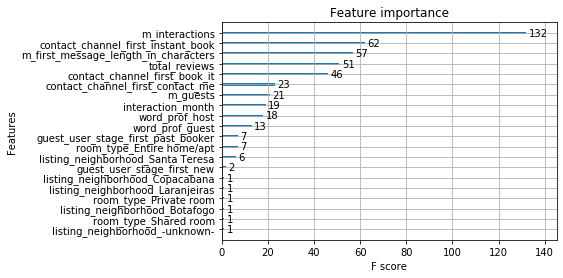

In [30]:
plot_importance(model)
pyplot.show()

Observations:
We can see that the most critical features towards the prediction of whether the booking will be made or not are: m_interactions, instant book, total reviews, The first message, book it, contact me, interaction month, word prof host, m guests, room type_home, past booker


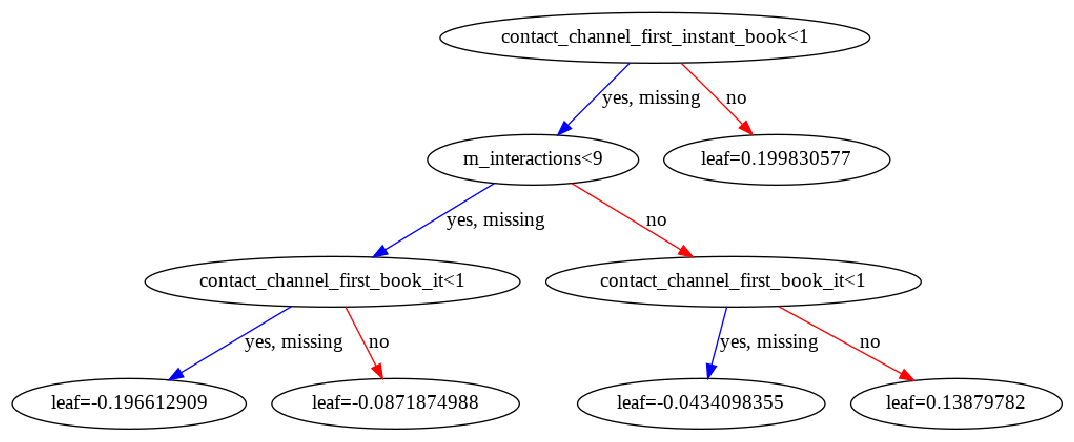

In [31]:
rcParams['figure.figsize'] = 19,19
plot_tree(model)

Takeaways

> Priority in the type of booking: instant_book > book_it > contact_me



